# Linguaggio Stan {#sec-stan}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [1]:
import os
import tempfile
import pandas as pd
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import logging
import statistics as stat

import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

In [3]:
seed: int = sum(map(ord, "beta_binomial_model"))
rng: np.random.Generator = np.random.default_rng(seed=seed)
sns.set_theme(palette="colorblind")
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = "retina"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'psicometria')

## Introduzione

Stan implementa una versione più efficiente dell'algoritmo di Metropolis (@sec-metropolis) chiamata *Hamiltonian Monte Carlo* (HMC), che viene ulteriormente ottimizzata in Stan attraverso l'algoritmo NUTS (*No-U-Turn Sampler*). Sebbene l'algoritmo di Metropolis e NUTS producano la stessa soluzione finale, l'algoritmo di Metropolis richiede un numero molto maggiore di iterazioni per raggiungere una condizione di equilibrio, dove i valori prodotti possono essere considerati equivalenti a un campione casuale estratto dalla distribuzione a posteriori desiderata. Questo aspetto diventa particolarmente critico nei modelli complessi, dove la convergenza può richiedere un grande numero di iterazioni, comportando tempi di calcolo molto lunghi. Di conseguenza, l'efficienza del campionamento diventa essenziale. Dal punto di vista concettuale, dunque, ciò che l'algoritmo di Metropolis e NUTS producono è sostanzialmente lo stesso: una catena di campioni che riflette la distribuzione a posteriori target. La differenza principale risiede nella velocità con cui NUTS raggiunge questo obiettivo, rendendolo una scelta preferibile per modelli complessi.

In questo capitolo, introdurremo un linguaggio di programmazione probabilistica (PPL) chiamato [Stan](https://mc-stan.org/users/documentation/). Stan ci permette di campionare da distribuzioni di probabilità costruendo una catena di Markov, la cui distribuzione di equilibrio (o stazionaria) coincide con la distribuzione desiderata. Il nome del linguaggio onora Stanislaw Ulam, uno dei pionieri del metodo Monte Carlo. Per maggiori informazioni, si veda l'@sec-stan-appendix.

Stan è un linguaggio altamente versatile, compatibile con diverse piattaforme e linguaggi di programmazione, tra cui R, Python e Julia. In questo corso, ci concentreremo su CmdStanPy, un'interfaccia Python che semplifica l'utilizzo di Stan. CmdStanPy agisce come un ponte tra Python e CmdStan, l'interfaccia a riga di comando di Stan implementata in C++. Le istruzioni per [installare](https://mc-stan.org/cmdstanpy/installation.html) CmdStanPy e i componenti necessari di CmdStan dal repository `conda-forge` sono disponibili nell'@sec-virtual-env. Oltre a CmdStanPy, esistono altre interfacce come cmdstanr per R, Stan.jl per Julia e MatlabStan per Matlab, offrendo una vasta gamma di opzioni per integrare Stan nel proprio flusso di lavoro.

## Stan e la Programmazione Probabilistica

La *programmazione probabilistica* rappresenta un innovativo paradigma nel campo dell'informatica, che fonde i principi della teoria della probabilità con quelli della programmazione. Questo approccio consente di sviluppare modelli e algoritmi capaci di gestire l'incertezza e la casualità in modo efficace e intuitivo.

Al cuore di questo paradigma si trova la capacità di costruire sistemi che ragionano su dati incerti e prendono decisioni informate. La programmazione probabilistica si colloca all'intersezione tra machine learning, statistica e linguaggi di programmazione, con l'obiettivo primario di semplificare e automatizzare il processo di inferenza bayesiana.

I Linguaggi di Programmazione Probabilistica (PPL) offrono un framework potente per formalizzare modelli bayesiani ed eseguire inferenze complesse. L'utente è chiamato principalmente a formulare il modello e, eventualmente, a selezionare un metodo di campionamento appropriato. Dopodiché, il processo di inferenza può essere avviato con relativa semplicità, quasi come se si trattasse di premere un "pulsante di inferenza".

In essenza, un programma probabilistico deve possedere due capacità fondamentali:

1. L'abilità di estrarre valori casuali da distribuzioni di probabilità.
2. La capacità di condizionare i valori delle variabili nel programma sulla base di osservazioni.

Tra i vari PPL disponibili, in questo insegnamento utilizzeremo Stan. Stan offre un ambiente robusto e flessibile per la modellazione bayesiana, combinando potenza computazionale e facilità d'uso, rendendolo ideale sia per scopi didattici che per applicazioni pratiche avanzate.


### Struttura di un Programma Stan

Un programma Stan richiede la specificazione di variabili e parametri, definendo le distribuzioni *a priori* per i parametri del modello statistico e la funzione di verosimiglianza. In sostanza, un programma Stan descrive la relazione tra i dati e i parametri, oltre alle distribuzioni probabilistiche che governano questi parametri. Questo permette di effettuare inferenze sulle distribuzioni *a posteriori* dei parametri del modello, dedotte sia dai dati osservati che dalle distribuzioni *a priori* definite dall'utente.

### Esecuzione di un Programma Stan

Stan utilizza metodi come il Monte Carlo a catena di Markov (MCMC) per generare campioni dalle distribuzioni *a posteriori*. Oltre all'MCMC, Stan supporta anche metodi approssimativi, come l'*inferenza variazionale*, che forniscono stime più rapide delle distribuzioni *a posteriori*, pur sacrificando parte della precisione.

Stan può anche generare dati simulati attraverso procedure pseudo-casuali in due contesti principali:

1. **Simulazione in avanti**: dove i dati vengono generati a partire da parametri di modello noti.
2. **Inferenza inversa**: dove, partendo dai dati osservati e dalle distribuzioni *a priori*, si stima la distribuzione *a posteriori* dei parametri del modello.

## Simulazione in Avanti

La *simulazione in avanti* consiste nella generazione di dati simulati a partire da un insieme di parametri noti del modello probabilistico. In altre parole, dato un insieme di ipotesi sui parametri del modello, la simulazione in avanti permette di prevedere i possibili risultati che ci aspetteremmo osservare.

Ad esempio, consideriamo uno studio clinico con $N$ soggetti e una probabilità $\theta$ di esito positivo per ciascun soggetto. Sapendo il valore di $\theta$ e il numero di soggetti $N$, possiamo utilizzare una distribuzione binomiale per simulare il numero di pazienti che avranno un esito positivo. Questo processo ci consente di generare dati che riflettono le nostre ipotesi sui parametri del modello.

In notazione statistica, questo scenario si esprime come segue:

$$
Y \sim \text{Binomiale}(N, \theta)
$$

dove $Y$ rappresenta il numero di esiti positivi su $N$ pazienti, con probabilità $\theta$ di esito positivo per ciascun paziente.

Supponiamo di avere $N = 100$ soggetti in uno studio clinico e un tasso di successo $\theta = 0.3$. Possiamo simulare il risultato $Y$, generando casualmente il numero di soggetti con esito positivo. Utilizzando la distribuzione binomiale, possiamo calcolare la probabilità di ottenere esattamente $y$ esiti positivi su $N$ tentativi con la seguente formula:

$$
p(Y = y \mid N, \theta) = \binom{N}{y} \cdot \theta^y \cdot (1 - \theta)^{N - y}
$$

Questa espressione ci consente di calcolare la probabilità di osservare un certo numero di successi, dato il numero totale di soggetti e la probabilità di successo per ciascuno di essi.

In altre parole, possiamo utilizzare Stan per generare campioni casuali da una distribuzione binomiale, proprio come potremmo fare in Python utilizzando librerie come `numpy`. Ad esempio, in Python, possiamo generare valori casuali da una distribuzione binomiale nel seguente modo:

In [4]:
# Genera 20 valori casuali da una distribuzione binomiale con n=100 e p=0.3
random_values = np.random.binomial(n=100, p=0.3, size=20)
print(random_values)

[27 29 27 31 30 21 30 34 31 26 35 18 29 30 34 36 29 25 26 36]


Analogamente, possiamo fare lo stesso in Stan per eseguire simulazioni in avanti e studiare i risultati previsti sulla base dei nostri parametri assunti.

### Un Primo Programma in Stan: Generazione di Dati Casuali

Supponiamo di voler generare valori casuali $Y$ da una distribuzione binomiale con parametri $N = 100$ e $\theta = 0.3$. Questo può essere realizzato utilizzando il seguente programma Stan:

```stan
data {
  int<lower=0> N;
  real<lower=0, upper=1> theta;
}

generated quantities {
  int<lower=0, upper=N> y;
  y = binomial_rng(N, theta);
}
```

## Organizzazione di un Programma Stan

La prima cosa da notare è che un programma Stan è strutturato in blocchi. In questo esempio, abbiamo due blocchi principali: il *blocco dei dati* (`data`), che contiene le dichiarazioni delle variabili da fornire come input, e il *blocco delle quantità generate* (`generated quantities`), che non solo dichiara le variabili, ma assegna anche dei valori. In questo programma Stan, la variabile `y` viene assegnata come risultato di una singola estrazione da una distribuzione $\textrm{binomiale}(N, \theta)$, utilizzando la funzione `binomial_rng` fornita da Stan.

### Tipi di Variabili in Stan

La seconda cosa da notare è che in un programma Stan tutte le variabili devono essere dichiarate con tipi specifici. Stan utilizza la _tipizzazione statica_, il che significa che, a differenza di linguaggi come Python o R, il tipo di una variabile deve essere dichiarato esplicitamente nel programma prima che venga utilizzata, e non viene determinato dinamicamente durante l'esecuzione in base al valore assegnato. Una volta dichiarato, il tipo di una variabile rimane invariato.

Nel programma in esame, vengono dichiarate tre variabili: `N` e `y`, entrambe di tipo `int` (intero), e `theta`, di tipo `real` (numero reale). 

### Vincoli sui Tipi

Le variabili in Stan possono avere dei vincoli specifici. Ad esempio, poiché `N` rappresenta un conteggio, deve essere maggiore o uguale a zero; questo è indicato con il vincolo `lower=0`. Allo stesso modo, la variabile `y`, che rappresenta il numero di successi su `N` tentativi, deve essere compresa tra 0 e `N` (inclusi), e questo è specificato con il vincolo `lower=0, upper=N`. Infine, la variabile `theta`, essendo una probabilità, deve essere compresa tra 0 e 1, il che viene espresso con il vincolo `lower=0, upper=1`. Sebbene tecnicamente i limiti per i numeri reali siano aperti, in pratica è possibile ottenere valori di 0 o 1 a causa di errori di arrotondamento nei calcoli.

### Esecuzione del Programma Stan

Per eseguire un programma Stan, il primo passo è compilare il codice Stan. Questo può essere fatto utilizzando la funzione `cmdstan_model()`. Tale funzione crea un oggetto `CmdStanModel` a partire da un file contenente il codice Stan. In background, CmdStan traduce il programma Stan in codice C++ e genera un eseguibile compilato, che potrà poi essere utilizzato per eseguire il modello.

Per fare un esempio, consideriamo il codice Stan che definisce soltanto i vincoli della variabile `y`. La variabile `y` ha valore minimo uguale a 0 e valore massimo 100. Se non specifichiamo nient'altro, Stan genererà un campione casuale di valori `y` con queste caratteristiche.

In [5]:
# Define the Stan model code
model_code_1 = """
parameters{
    real<lower=0, upper=100> y;
}
"""

# Create a temporary file for the Stan model
with tempfile.NamedTemporaryFile(suffix=".stan", mode="w", delete=False) as f:
    f.write(model_code_1)
    stan_file = f.name

Compiliamo il modello salvato nel file temporaneo `model_code_1.stan`:

In [6]:
model_1 = CmdStanModel(stan_file=stan_file)

Eseguiamo il campionamento MCMC:

In [15]:
samples_1 = model_1.sample(
    data={},
    seed=123,
    chains=4,
    parallel_chains=4, # No data needed for this model
    show_progress=False, 
    show_console=False
)

In [8]:
# Print summary of the samples
print(samples_1.summary())

          Mean      MCSE     StdDev       5%       50%      95%    N_Eff  \
lp__   2.62356  0.023407   0.813402  1.01076   2.93862   3.2163  1207.62   
y     51.68350  0.742127  28.626100  6.02640  51.84290  94.9665  1487.88   

      N_Eff/s    R_hat  
lp__  21956.8  1.00196  
y     27052.3  1.00070  


In [9]:
# Convert to a NumPy array for plotting
posterior_draws = samples_1.draws_pd()  # Get samples as pandas DataFrame
y_samples = posterior_draws["y"]

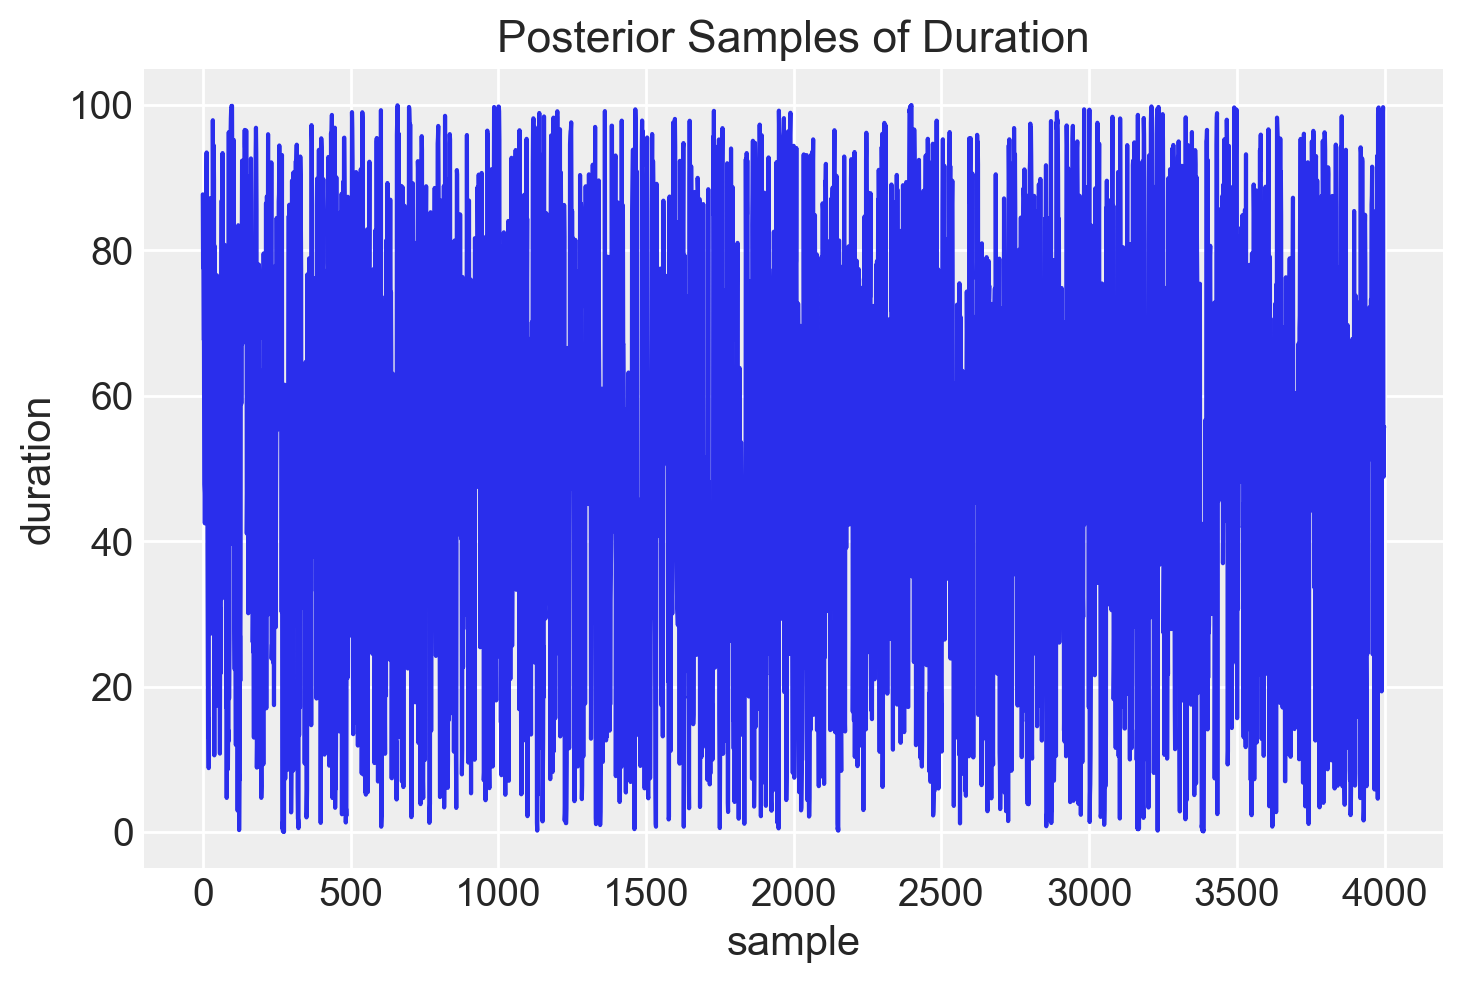

In [10]:
# Plot the posterior samples
plt.plot(y_samples, label="duration")
plt.xlabel("sample")
plt.ylabel("duration")
plt.title("Posterior Samples of Duration")
plt.show()

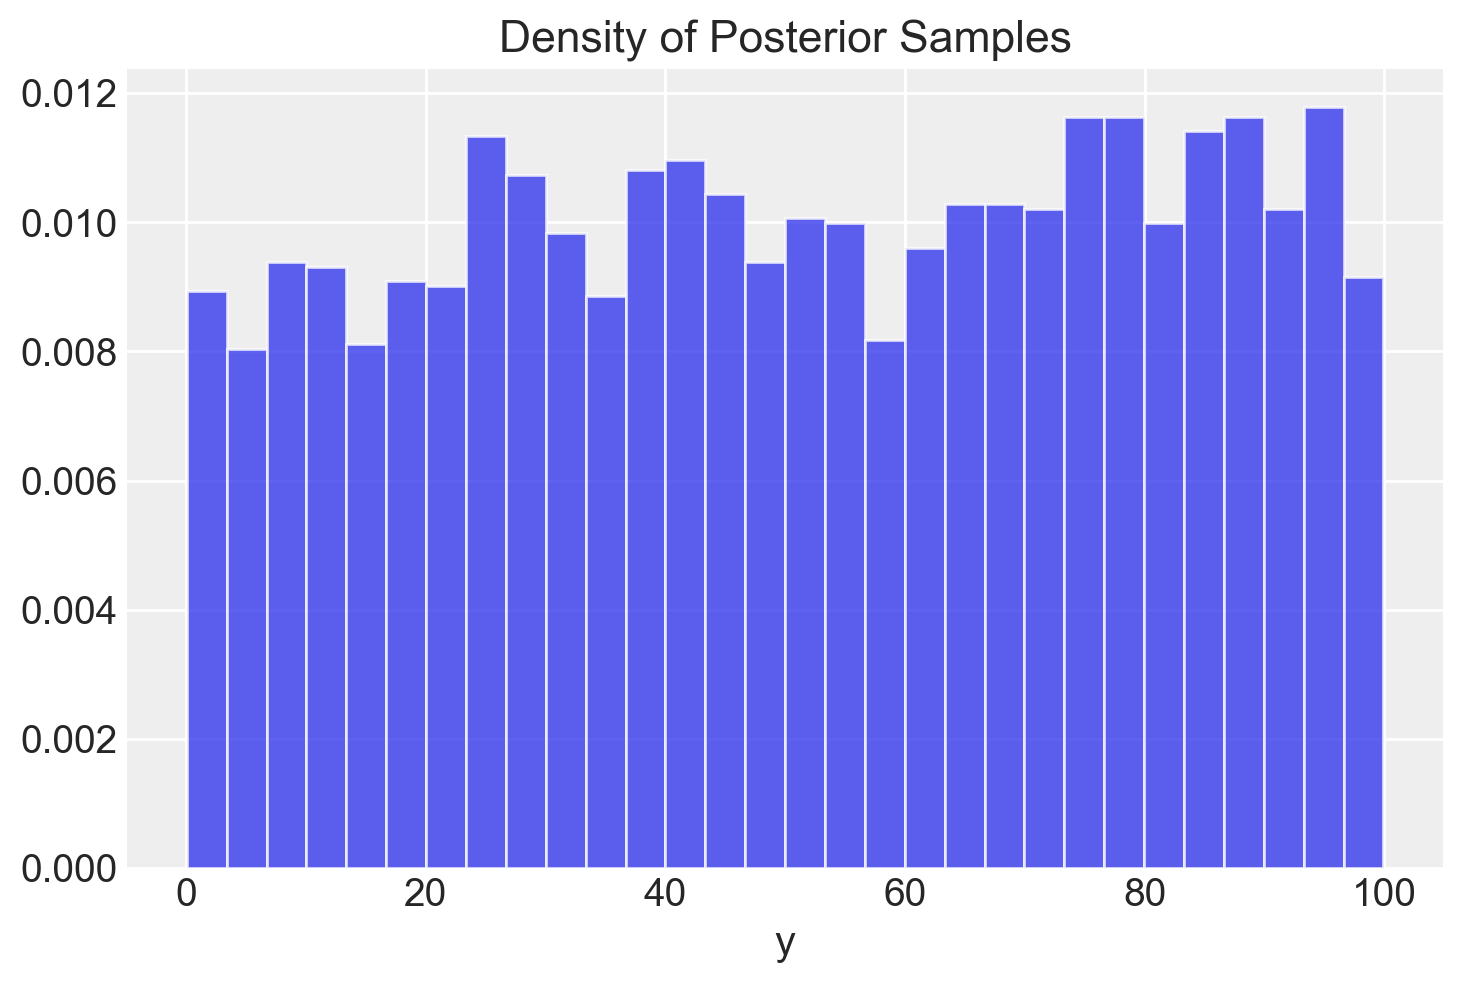

In [11]:
# Plot the density of the posterior samples
plt.hist(y_samples, bins=30, density=True, alpha=0.75)
plt.xlabel("y")
plt.title("Density of Posterior Samples")
plt.show()

In questo modo abbiamo generato un campione casuale di valori dalla distribuzione uniforme nell'intervallo [0, 100]. Tuttavia, il nostro obiettivo è ottenere 20 valori `y` estratti casualmente da una distribuzione binomiale $\text{Binomial}(N, \theta)$. Per farlo, modifichiamo il programma Stan come segue.

In [12]:
stan_file = os.path.join(project_directory, "stan", "binomial-rng.stan")
model = CmdStanModel(stan_file=stan_file)
print(model.code())

data {
  int<lower=0> N;
  real<lower=0, upper=1> theta;
}
generated quantities {
  int<lower=0, upper=N> y = binomial_rng(N, theta);
}



Nel blocco `data`, specifichiamo due parametri: `N` (il numero di prove Bernoulliane indipendenti) e `theta` (la probabilità di successo per ciascuna prova). A questi dati vengono applicati vincoli che ne garantiscono la validità: `N` deve essere un numero intero positivo, mentre `theta` deve essere un valore compreso tra 0 e 1.

Il secondo blocco, `generated quantities`, utilizza la funzione `binomial_rng()`, che genera valori casuali da una distribuzione binomiale, usando i parametri specificati (`N` e `theta`).

Durante l'esecuzione, il modello Stan richiede come input i valori di `N` e `theta`. A ogni iterazione, il programma campiona un valore di `y` utilizzando il suo generatore di numeri pseudocasuali integrato. Per eseguire il modello, i valori di `N` e `theta` devono essere forniti in un dizionario Python, che verrà passato come input al programma.

In [13]:
N = 100
theta = 0.3
data = {
    'N': N, 
    'theta': theta
}

Infine campioniamo dal modello utilizzando il metodo `sample` di `CmdStanModel`.

In [14]:
trace = model.sample(
    data=data, 
    seed=123, 
    chains=1,
    iter_sampling=20, 
    iter_warmup=1,
    show_progress=False, 
    show_console=False
)

Nell'interfaccia Python, il metodo `sample()` accetta i seguenti argomenti:

- `data`: i dati letti nel blocco dati del programma Stan,
- `seed`: generatore di numeri pseudocasuali per la riproducibilità,
- `chains`: il numero di simulazioni da eseguire (`parallel_chains` indica quante eseguire in parallelo),
- `iter_sampling`: numero di estrazioni (cioè, dimensione del campione) da restituire,
- `iter_warmup`: numero di iterazioni di riscaldamento per tarare i parametri dell'algoritmo di campionamento (non necessari qui, quindi impostato a 0),
- `show_progress`: se `True`, stampa aggiornamenti di progresso,
- `show_console`: apre un monitor di progresso GUI.

Il risultato della chiamata a `sample()` sull'istanza del modello viene assegnato alla variabile `trace` e contiene le 20 estrazioni richieste con l'argomento `iter_sampling = 20`.

Quando si chiama `model.sample(...)`, CmdStan esegue Stan come programma C++ autonomo in un processo in background. Questo programma inizia copiando i dati forniti nell'argomento `data` di Python in un file, quindi legge quel file di dati per costruire un oggetto C++ che rappresenta il modello statistico. Poiché il nostro programma Stan ha solo un blocco di quantità generate, l'unico compito rimanente della classe C++ è generare il numero richiesto di estrazioni. Per ciascuna delle estrazioni specificate da `iter_sampling`, Stan utilizza un generatore di numeri pseudocasuali per ottenere un valore dalla distribuzione binomiale specificata.

La generazione di numeri casuali è determinata dal valore `seed` specificato nella chiamata. 

### Estrazione dei Risultati

Una volta completato il campionamento, possiamo estrarre il campione di 20 valori per la variabile scalare `y` sotto forma di array e quindi stampare i loro valori insieme ai valori delle variabili di input.

In [17]:
y = trace.stan_variable('y')
print("N =", N, ";  theta =", theta, ";  y =", *y.astype(int))

N = 100 ;  theta = 0.3 ;  y = 28 34 31 29 26 25 31 28 30 36 29 36 37 27 29 23 29 34 30 42


Questo è un esempio di simulazione "forward", ossia la generazione di dati simulati a partire da un modello probabilistico con parametri noti.

## Il Problema Inverso

Il problema inverso riguarda la stima dei parametri di un modello (come la probabilità di successo $\theta$ nell'esempio precedente) a partire da un campione di dati osservati.

Per illustrare come affrontare il problema inverso utilizzando Stan, consideriamo un esperimento Go-No Go in cui sono stati osservati 6 successi su 9 prove. La verosimiglianza di questi dati segue una distribuzione binomiale con parametro di successo $\theta$ sconosciuto. Come in precedenza, imponiamo una distribuzione uniforme come prior per $\theta$. L'obiettivo è stimare la distribuzione a posteriori di $\theta$, ovvero la probabilità di successo.

È noto che la distribuzione a posteriori di $\theta$, dato un risultato osservato $y$ e un prior Beta, segue anch'essa una distribuzione Beta, con parametri aggiornati che si ottengono sommando $y$ a $\alpha$ e $N-y$ a $\beta$. In altre parole, la distribuzione a posteriori è:

$$
\theta \mid y \sim \text{Beta}(\alpha + y, \beta + N - y).
$$

Se scegliamo un prior non informativo con $\alpha = 1$ e $\beta = 1$, otteniamo:

$$
\theta \mid y \sim \text{Beta}(1 + 6, 1 + 9 - 6) = \text{Beta}(7, 4).
$$

In questo caso, la distribuzione a posteriori di $\theta$ è una $\text{Beta}(7, 4)$, che riflette l'informazione aggiornata dal campione di dati osservati.

Utilizzando Stan, possiamo campionare da questa distribuzione a posteriori per calcolare statistiche riassuntive e fare previsioni.

In sintesi, la **simulazione forward** e il **problema inverso** sono due approcci complementari: la simulazione forward genera dati simulati a partire da parametri noti, mentre il problema inverso consente di stimare i parametri del modello utilizzando dati osservati.

Ecco come possiamo specificare il modello Stan:

In [18]:
stan_file = os.path.join(project_directory, "stan", "go_nogo_model.stan")
model_go_nogo = CmdStanModel(stan_file=stan_file)
print(model_go_nogo.code())

data {
  int<lower=1> N;
  int<lower=0> y;
}
parameters {
  real<lower=0, upper=1> p;
}
model {
  y ~ binomial(N, p); // Likelihood
  p ~ beta(1, 1); // Prior
}
generated quantities {
  int<lower=0, upper=1> p_gt_chance = p > 0.5;
}



In questo programma Stan, vediamo che il numero totale di prove (`n`) e il numero di successi (`y`) vengono forniti come dati. Successivamente, sono presenti due blocchi aggiuntivi: un *blocco dei parametri*, utilizzato per dichiarare i valori sconosciuti (in questo caso, la probabilità di rispondere correttamente, `p`), e un *blocco del modello*, dove vengono specificate la distribuzione a priori e la verosimiglianza. Stan calcola la distribuzione a posteriori combinando queste due componenti. Inoltre, è presente un *blocco delle quantità generate* in cui viene calcolata una variabile booleana che indica se la probabilità di risposta corretta è maggiore di 0.5.

Il modello bayesiano e la sua implementazione in Stan ci permettono di affrontare il problema inverso: inferire la probabilità di una risposta corretta (inibizione nelle prove No-Go) a partire dai dati osservati. Utilizzando Stan, possiamo stimare non solo la probabilità di rispondere correttamente nelle prove No-Go, ma anche la probabilità che tale probabilità sia superiore al valore atteso per caso (`p_gt_chance`).

### Campionare dalla Distribuzione a Posteriori

Quando eseguiamo un programma Stan, vengono generati campioni casuali che approssimano la distribuzione a posteriori. Con l'aumentare del numero di campioni, questi si avvicinano sempre più a veri campioni della distribuzione a posteriori.

Stan utilizza un algoritmo Markov Chain Monte Carlo (MCMC), che può introdurre autocorrelazione tra i campioni, cioè i campioni successivi sono correlati tra loro. Sebbene l'autocorrelazione non crei bias, può aumentare la varianza delle stime, rendendo meno precise le stime nei modelli più complessi.

Per migliorare l'efficienza del campionamento, specialmente nei modelli ad alta dimensionalità, Stan utilizza un algoritmo chiamato No-U-Turn Sampler (NUTS), che è una versione avanzata dell'Hamiltonian Monte Carlo (HMC). NUTS può generare campioni anti-correlati, riducendo la varianza e migliorando la precisione delle stime rispetto ai campioni indipendenti.

### Compilazione del Codice Stan

Per utilizzare Stan, dobbiamo compilare il codice del modello. Questo crea un file eseguibile che, nel nostro caso, abbiamo chiamato `model_go_nogo`:

```python
model_go_nogo = CmdStanModel(stan_file=stan_file)
```

Inseriamo i dati richiesti in un dizionario.

In [19]:
stan_data = {"N": 9, "y": 6}
print(stan_data)

{'N': 9, 'y': 6}


Eseguiamo il campionamento con la seguente chiamata:

In [20]:
fit = model_go_nogo.sample(
    data=stan_data,
    iter_warmup=2000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

Il metodo `.sample()` viene applicato al file eseguibile del modello Stan che abbiamo compilato e nominato `model_go_nogo`.

Assumendo una distribuzione a priori per il parametro `p`, l'algoritmo procede iterativamente, aggiornando la distribuzione a priori di `p` condizionandola ai valori già generati. Dopo un certo numero di iterazioni, l'algoritmo raggiunge la convergenza, e i valori estratti possono essere considerati campioni dalla distribuzione a posteriori di `p`.

All'inizio del campionamento, la distribuzione dei campioni può essere significativamente diversa dalla distribuzione stazionaria. Questo periodo iniziale è chiamato "burn-in". Durante il burn-in, i campioni possono non rappresentare accuratamente la distribuzione a posteriori e vengono tipicamente scartati. Con l'aumentare del numero di iterazioni, la distribuzione dei campioni si avvicina sempre più alla distribuzione target.

Una volta eseguito il modello in Stan, otteniamo una serie di campioni di `p` dalla distribuzione a posteriori $p(p \mid N, y)$. Ogni campione rappresenta un possibile valore di `p` compatibile con i dati osservati `y`. Procediamo quindi a estrarre i campioni a posteriori per le variabili `p` e `p_gt_chance`.

In [21]:
p_draws = fit.stan_variable("p")
p_gt_chance_draws = fit.stan_variable("p_gt_chance")

Tracciando un istogramma di questi campioni, possiamo visualizzare dove i valori di `p` sono più probabili e comprendere meglio la forma della distribuzione a posteriori. L'istogramma ci fornisce diverse informazioni:

- **Valore più probabile di `p`**: Questo è il valore intorno al quale i campioni sono più concentrati, noto come la moda della distribuzione.
- **Distribuzione dei possibili valori di `p`**: Questo ci dà un'idea dell'incertezza nella stima di `p`.

Se l'istogramma è stretto e concentrato attorno a un valore specifico, significa che c'è poca incertezza nella stima di `p`. In altre parole, possiamo essere abbastanza sicuri che il valore vero di `p` sia vicino a questo valore. Se l'istogramma è largo e distribuito, significa che c'è maggiore incertezza nella stima di `p`. Questo indica che i dati osservati non forniscono una stima precisa e che il valore di `p` potrebbe variare notevolmente.

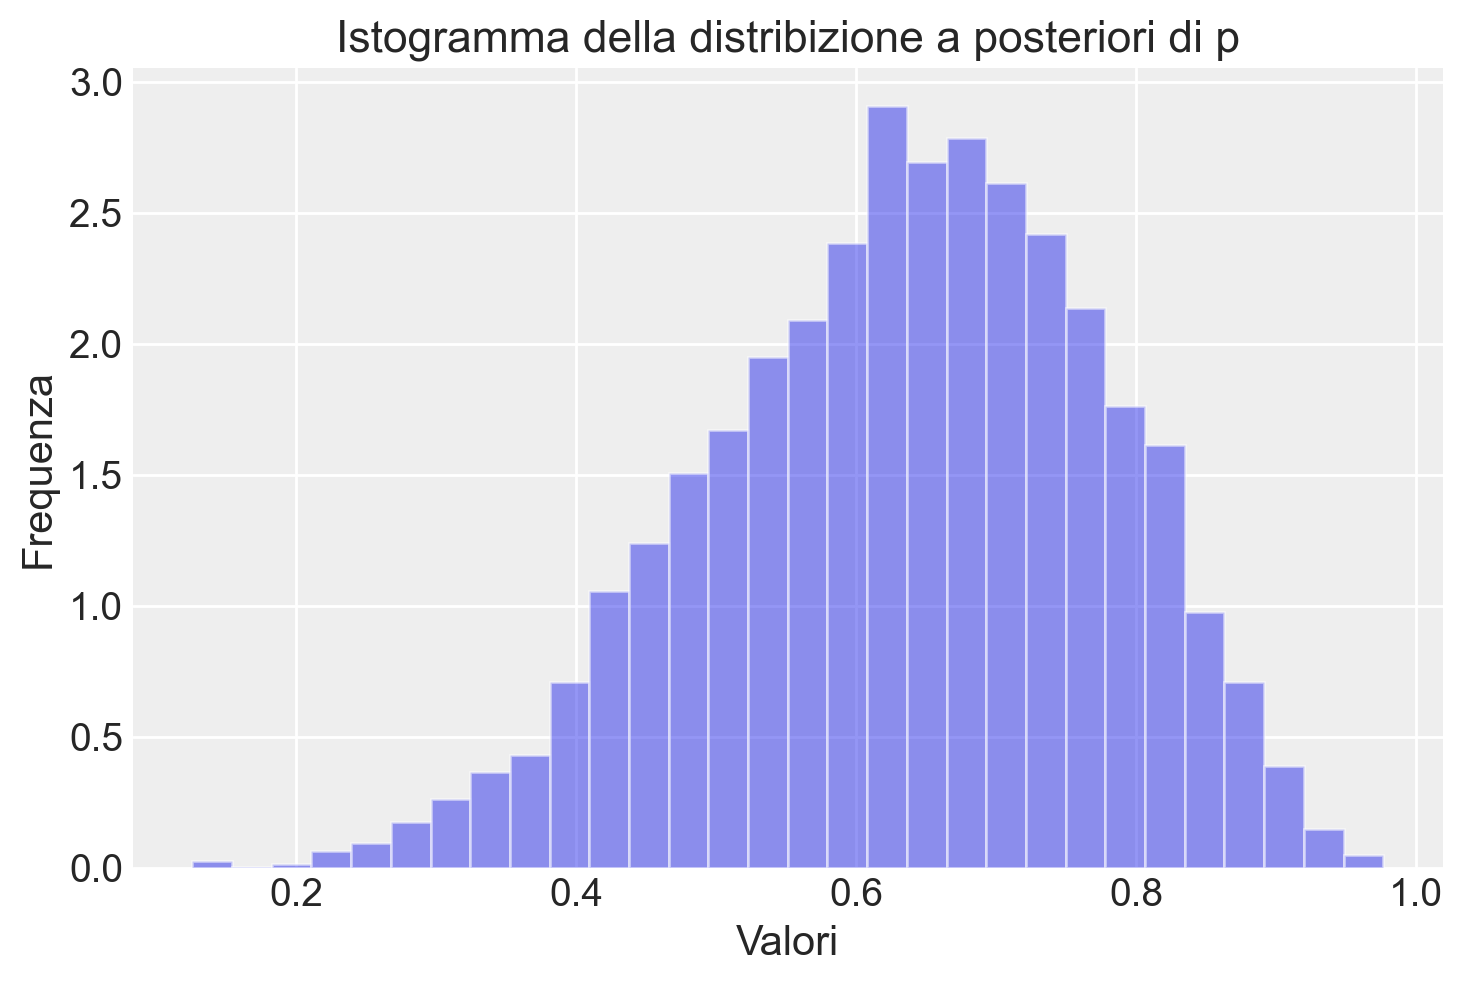

In [22]:
plt.hist(
    p_draws,
    bins=30,
    alpha=0.5,
    density=True,
)
plt.title("Istogramma della distribizione a posteriori di p")
plt.xlabel("Valori")
plt.ylabel("Frequenza")
plt.show()

Con un numero così piccolo di prove la nostra incertezza relativamente al valore vero di $p$ è enorme. Si noti la corrispondenza tra questo istogramma e quello calcolato "manualmente" nella @sec-metropolis-1.

## Prior Debolmente Informativi

Consideriamo ora una seconda versione del modello Stan precedente, con l'unica differenza che questa volta utilizzeremo una distribuzione a priori debolmente informativa. Torniamo ai dati sulla proporzione di artisti della Generazione X presenti al MoMA. In precedenza, abbiamo osservato che 14 artisti su un campione di 100 appartenevano alla Generazione X. Per costruire un esempio in cui la distribuzione a posteriori differisce significativamente dalla verosimiglianza, impostiamo una distribuzione a priori Beta(4, 6) per $\theta$, la probabilità che un artista appartenga alla Generazione X. Il codice Stan aggiornato è quindi il seguente.

In [24]:
stan_file = os.path.join(project_directory, "stan", "moma_model.stan")
model_moma = CmdStanModel(stan_file=stan_file)
print(model_moma.code())

data {
  int<lower=0> N;
  int<lower=0, upper=N> y;
  int<lower=0> alpha_prior;
  int<lower=0> beta_prior;
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  theta ~ beta(alpha_prior, beta_prior);
  y ~ binomial(N, theta);
}
generated quantities {
  int<lower=0, upper=N> y_rep;
  int<lower=0, upper=1> theta_gt_025 = theta > 0.25;
  
  y_rep = binomial_rng(N, theta);
}



Creiamo un dizionario con i dati.

In [25]:
data_moma = {
    "N": 100,
    "y": 14,
    "alpha_prior": 4,
    "beta_prior": 6
}
print(stan_data)

{'N': 9, 'y': 6}


Eseguiamo il campionamento.

In [26]:
fit_moma = model_moma.sample(
    data=data_moma,
    iter_warmup=2_000,
    iter_sampling=2_000,
    seed=42,
    show_progress=False,
    show_console=False,
)

Esaminiamo la distribuzione a posteriori del parametro $\theta$.

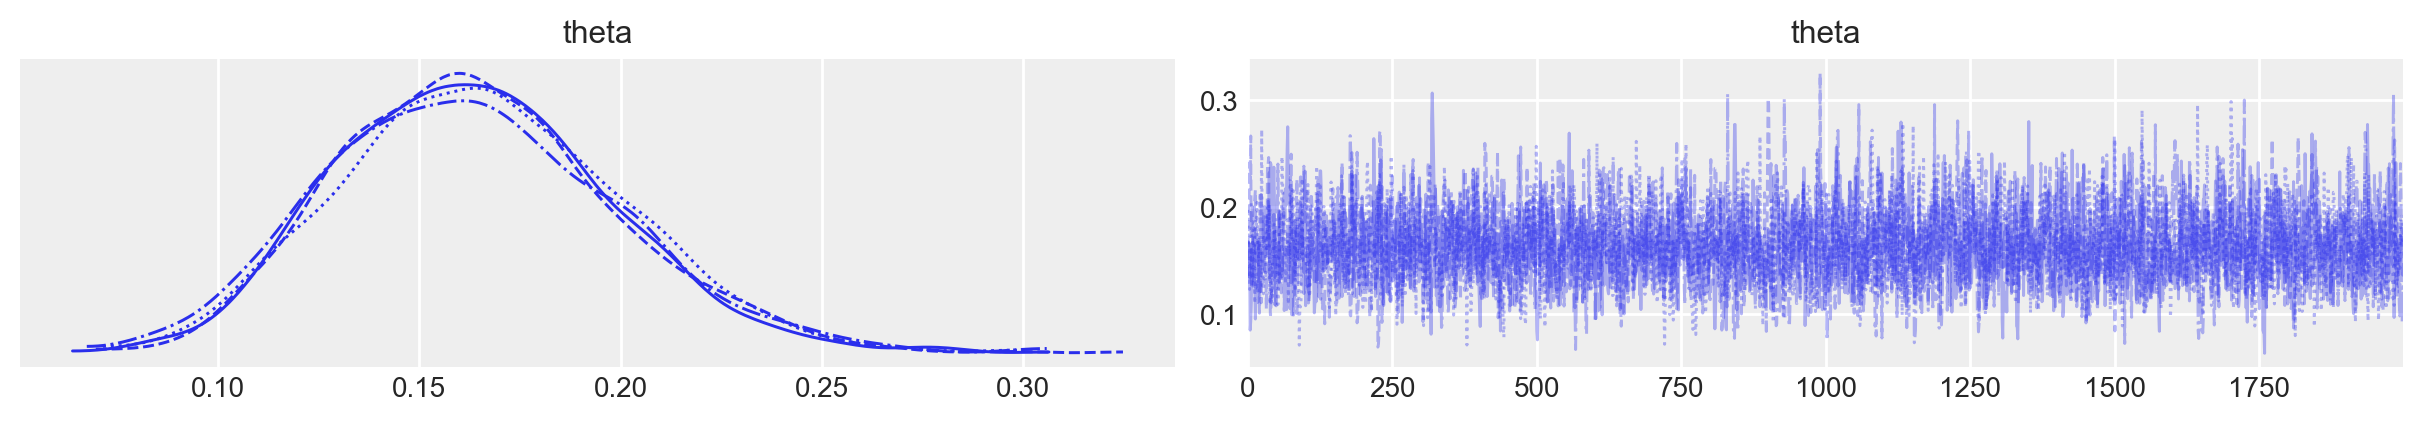

In [41]:
_ = az.plot_trace(fit_moma, var_names=("theta"))

In [28]:
az.summary(fit_moma, var_names=("theta"), kind="stats", hdi_prob=0.94, round_to=2)

,mean,sd,hdi_3%,hdi_97%
theta,0.16,0.03,0.1,0.23


Si noti come la stima putuale a posteriori e l'intervallo di credibilità riproducono i valori ottenuti utilizzando l'algoritmo di Metropolis nella @sec-moma-post-estimates.

## Utilizzo di Dati Simulati per Comprendere il Modello

Nella sezione precedente abbiamo adattato un modello a un set di dati reale. Tuttavia, nella pratica è essenziale procedere con maggiore cautela ed esaminare attentamente il comportamento del nostro modello e dell'algoritmo di inferenza. Un metodo utile a tal fine è lavorare con dati simulati.

### Verifica dei Priors

Possiamo verificare se i nostri priors sono adeguati calcolando la probabilità a priori dei parametri di interesse. Ad esempio, nel nostro campione, sappiamo che la proporzione di artisti appartenenti alla Generazione X è 0.14. È importante che i priors consentano configurazioni ragionevoli dei dati ma escludano scenari chiaramente assurdi, basandosi sulla nostra esperienza del dominio. Per verificare se i nostri priors soddisfano questo requisito, possiamo effettuare un <font color='orange'>prior predictive check</font>.

Per condurre un prior predictive check, utilizziamo lo stesso modello usato in precedenza, inseriamo i parametri di interesse nel blocco *generated_quantities* e rimuoviamo il termine relativo alla distribuzione di campionamento (ossia la verosimiglianza) dal modello. Senza la verosimiglianza, i parametri non vengono adattati ai dati e vengono quindi campionati dalla loro distribuzione a priori. Il codice Stan rimane identico a quello finale, ma senza la riga `y ~ binomial(N, theta);`. Un trucco utile per semplificare i prior predictive check è aggiungere uno switch `compute_likelihood` ai dati, come mostrato di seguito:

```stan
if (compute_likelihood == 1)
  y ~ binomial(N, theta);
```

Questo ci consente di utilizzare lo stesso file Stan per eseguire sia i prior predictive check che l'inferenza, semplicemente modificando il valore di `compute_likelihood`.

Definiamo innanzitutto il dizionario dei dati:

In [40]:
# Definiamo i dati
data_moma = {
    "N": 100,  # Number of trials
    "y": 0,  # Placeholder, not used during prior predictive checks
    "alpha_prior": 4,  # Values for Beta prior parameters
    "beta_prior": 6,
    "compute_likelihood": 0,  # Set to 0 to disable likelihood for prior predictive check
}

Compiliamo il modello Stan:

In [30]:
stan_file = os.path.join(project_directory, "stan", "moma_model_prior.stan")
model_moma_prior = CmdStanModel(stan_file=stan_file)

Il codice Stan associato è il seguente:

In [31]:
print(model_moma_prior.code())

data {
  int<lower=0> N;
  int<lower=0, upper=N> y;
  int<lower=0> alpha_prior;
  int<lower=0> beta_prior;
  int<lower=0, upper=1> compute_likelihood; // Flag to control likelihood inclusion
}
parameters {
  real<lower=0, upper=1> theta;
}
model {
  theta ~ beta(alpha_prior, beta_prior); // Prior for theta
  
  if (compute_likelihood == 1) {
    y ~ binomial(N, theta); // Likelihood is only included if compute_likelihood == 1
  }
}
generated quantities {
  int<lower=0, upper=N> y_rep;
  int<lower=0, upper=1> theta_gt_025 = theta > 0.25; // Indicator if theta > 0.25
  y_rep = binomial_rng(N, theta); // Simulated data for posterior predictive check
}



Eseguiamo il campionamento utilizzando solo la distribuzione a priori:

In [34]:
# Campionamento dalla distribuzione a priori (compute_likelihood settato a 0)
fit_prior = model_moma_prior.sample(
    data=data_moma,
    chains=4,
    iter_warmup=500,
    iter_sampling=1000,
    seed=123,
    show_progress=False,
    show_console=False
)

Estraiamo i campioni a priori per il parametro $\theta$:

In [35]:
theta_samples = fit_prior.stan_variable("theta")

Infine, creiamo un istogramma per visualizzare la distribuzione a priori di $\theta$:

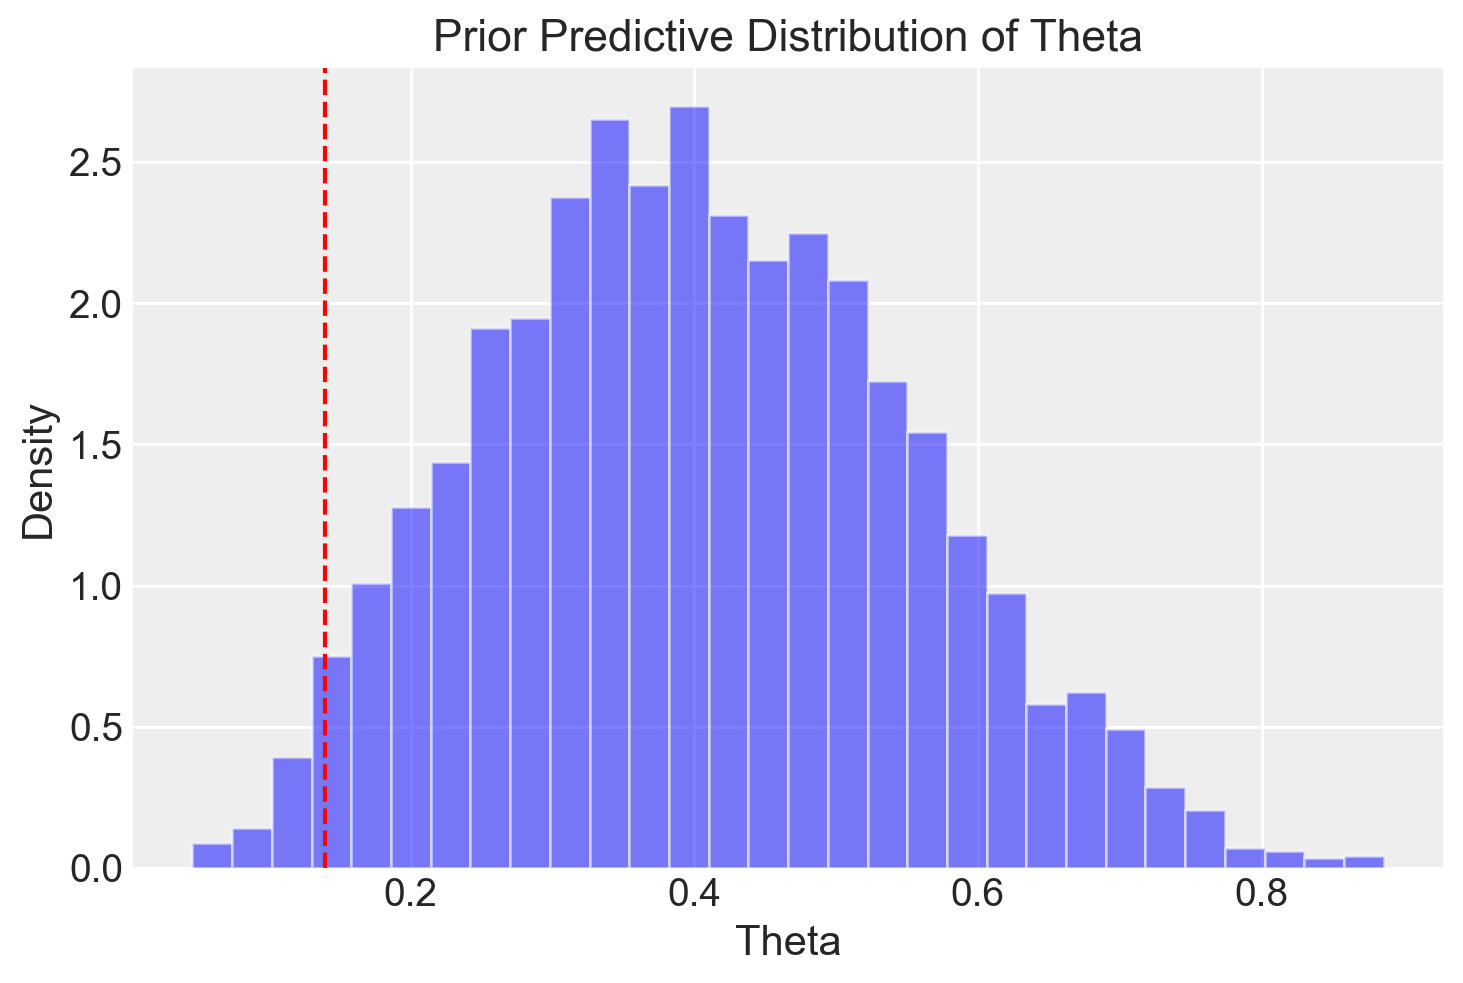

In [36]:
plt.hist(theta_samples, bins=30, density=True, alpha=0.5, color="blue")
plt.axvline(0.14, color="red", linestyle="--")  # Mark theta = 0.14 as in your example
plt.title("Prior Predictive Distribution of Theta")
plt.xlabel("Theta")
plt.ylabel("Density")
plt.show()

In conclusione, osserviamo che la distribuzione a priori per $\theta$ include la proporzione campionaria, ma la maggior parte della massa di probabilità si concentra su valori più elevati. Questo suggerisce che la scelta della distribuzione Beta come prior potrebbe non essere completamente ottimale per rappresentare il parametro in questione. Sarà necessario valutare se un prior diverso potrebbe migliorare l'inferenza, garantendo una rappresentazione più accurata delle conoscenze a priori e dei dati osservati.

## Stime Puntuali Bayesiane

In termini bayesiani, una _stima puntuale_ per un parametro $\Theta$ condizionato sui dati osservati $Y = y$ è un singolo valore $\hat{\theta} \in \mathbb{R}^D$ che riassume la distribuzione a posteriori $p(\theta \mid y)$. La notazione $\hat{\theta}$ è convenzionale nella statistica per indicare una stima di un parametro $\theta$. In questa sezione definiamo tre stimatori e discutiamo come i due stimatori bayesiani minimizzino una _funzione di perdita_ tra il valore vero e la stima. Torneremo alla funzione di perdita e alle proprietà degli stimatori dopo averli definiti.

### Stimatore della Media Posteriori

La stima puntuale bayesiana più comune per un parametro è la media posteriori,

$$
\begin{align}
\widehat{\theta}
&= \mathbb{E}[\Theta \mid Y = y] \\
&= \int_{\Theta} \theta \cdot p(\theta \mid y) \, \textrm{d}\theta \\
&= \lim_{M \rightarrow \infty} \, \frac{1}{M} \sum_{m=1}^M \theta^{(m)} \\
&\approx \frac{1}{M} \sum_{m=1}^M \theta^{(m)},
\end{align}
$$

dove nelle ultime due righe, ogni estrazione è distribuita approssimativamente secondo la distribuzione a posteriori,

$$
\theta^{(m)} \sim p(\theta \mid y).
$$

Abbiamo introdotto la notazione di _aspettativa condizionale_ nella prima riga di questa definizione. Le aspettative sono semplicemente medie ponderate, con i pesi dati da una densità di probabilità. L'inferenza bayesiana coinvolge aspettative sulla distribuzione a posteriori, la cui notazione concisa è quella dell'*aspettativa condizionale*,

$$
\mathbb{E}\!
\left[ f(\Theta) \mid Y = y \right]
= \int_{\mathbb{R^N}} f(\theta) \cdot p_{\Theta \mid Y}(\theta \mid y) \, \textrm{d}\theta,
$$

dove $\Theta$ e $Y$ sono variabili casuali, mentre $\theta$ e $y$ sono variabili vincolate ordinarie.

Per il modello precedente, la stima per il tasso di artisti della Generazione X rappresentato al MoMA, ovvero $\theta$, condizionata sui dati osservati $y$, è calcolata come la media campionaria delle estrazioni per `theta`.

In [45]:
theta = fit_moma.stan_variable("theta")
theta_hat = np.mean(theta)
print(f"estimated theta = {theta_hat:.3f}")

estimated theta = 0.164


### Stimatore della Mediana Posteriori, Quantili e Intervalli

Un'alternativa popolare alla stima puntuale bayesiana è la _mediana posteriori_, $\theta^+$. La mediana è il valore tale che, per ogni dimensione $d \in 1{:}D$,

$$
\Pr[\Theta_d \leq \theta^+_d] = \frac{1}{2}.
$$

In altre parole, la mediana è il valore che divide la distribuzione a posteriori in due parti uguali: il 50% dei campioni è al di sotto della mediana e il 50% è al di sopra. La mediana posteriori può essere calcolata prendendo la mediana dei campioni dalla distribuzione a posteriori.

Ecco come calcolare la mediana posteriori utilizzando Python:

In [46]:
theta_plus = np.median(theta)
print(f"estimated (median) theta = {theta_plus:.3f}")

estimated (median) theta = 0.162


Poiché la distribuzione a posteriori per i dati relativi agli artisti della Generazione X è quasi simmetrica, la media posteriori e la mediana posteriori sono molto simili.

### Quantili e Intervalli di Credibilità

Oltre alla mediana, possiamo anche calcolare i quantili e gli intervalli di credibilità per fornire ulteriori informazioni sulla distribuzione a posteriori. I quantili sono valori che dividono la distribuzione in intervalli con una probabilità specificata. Gli intervalli di credibilità indicano l'intervallo entro il quale cade una certa percentuale della distribuzione a posteriori.

#### Quantili

Ad esempio, se vogliamo calcolare il quantile al 95% della distribuzione a posteriori, possiamo semplicemente prendere il valore che si trova al 95° percentile nella sequenza ordinata dei campioni. Di seguito sono riportati i quantili al 5% e al 95% della distribuzione a posteriori per gli artisti della Generazione X, calcolati utilizzando i quantili empirici.

In [47]:
quantile_05 = np.quantile(theta, 0.05)
quantile_95 = np.quantile(theta, 0.95)
print(f"""0.05 quantile = {quantile_05:.3f};
0.95 quantile = {quantile_95:.3f}""")

0.05 quantile = 0.111;
0.95 quantile = 0.224


#### Intervalli Posteriori

Insieme, il quantile al 5% e al 95% ci forniscono i limiti del nostro _intervallo di probabilità centrale_ al 90%. Questo intervallo è definito come l'intervallo che contiene il 90% della massa di probabilità a posteriori, con il 5% della massa rimanente al di sotto dell'intervallo e il 5% al di sopra.

### Errore di Stima e Bias

L'_errore_ di una stima è la differenza tra la stima stessa e il valore vero del parametro,

$$
\textrm{err} = \hat{\theta} - \theta.
$$

La nostra stima $\hat{\theta}$ è implicitamente una funzione dei dati $y$, quindi anche l'errore dipende dai dati. Possiamo rendere esplicita questa dipendenza scrivendo

$$
\text{err}(y) = \hat{\theta}(y) - \theta.
$$

Il _bias_ di uno stimatore è definito come l'errore atteso, cioè la media dell'errore rispetto alla distribuzione dei dati per la variabile casuale $Y$,

$$
\begin{align}
\text{bias}
&= \mathbb{E}[\text{err}(Y)] \\
&= \mathbb{E}[\hat{\theta}(Y) - \theta] \\
&= \int_Y (\hat{\theta}(y) - \theta) \, \text{d}y.
\end{align}
$$

In altre parole, il bias misura quanto, in media, la stima $\hat{\theta}$ si discosta dal valore vero $\theta$ considerando tutte le possibili realizzazioni dei dati $Y$. Un bias nullo indica che lo stimatore è corretto in media, cioè non tende a sovrastimare o sottostimare il valore vero del parametro.

### Stimatore della Moda Posteriori

Uno stimatore popolare, sebbene non strettamente bayesiano, è la moda a posteriori, che rappresenta il valore del parametro $\theta$ per cui la densità a posteriori è massima. Formalmente, è definita come:

$$ 
\theta^* = \text{arg max}_\theta \ p(\theta \mid y). 
$$

La stima $\theta^*$ è spesso chiamata stima MAP (Maximum A Posteriori). La moda a posteriori non è considerata un vero stimatore bayesiano perché non tiene conto dell'incertezza nella stessa misura in cui lo fanno altri metodi bayesiani. In altre parole, non minimizza una funzione di perdita basata sui valori veri dei parametri, ma cerca semplicemente il valore più probabile dato i dati osservati.

### Caratteristiche della Moda Posteriori

- **Non considera l'incertezza**: La stima MAP si focalizza solo sul valore più probabile della distribuzione a posteriori, senza tenere conto della variabilità dei dati.
- **Massimo della densità a posteriori**: La moda a posteriori rappresenta il punto in cui la densità a posteriori raggiunge il suo massimo.
- **Possibili limitazioni**: La stima MAP potrebbe non esistere in alcuni casi, come nei modelli in cui la densità cresce senza limiti. Questo può accadere, ad esempio, nei modelli bayesiani gerarchici o in distribuzioni semplici come la distribuzione esponenziale con parametro 1 ($\textrm{esponenziale}(1)$).

### Funzioni di Perdita e Proprietà degli Stimatori

La media a posteriori è uno stimatore bayesiano popolare per due ragioni principali. Primo, è uno stimatore non distorto, il che significa che ha un bias nullo. Secondo, ha l'errore quadratico medio atteso minimo tra tutti gli stimatori non distorti. L'errore quadratico di una stima è definito come:

$$ 
\text{err}^2(y) = \left(\hat{\theta}(y) - \theta\right)^2. 
$$

Questa è una funzione di perdita, che misura la differenza tra una stima $\hat{\theta}$ e il valore vero $\theta$. Tuttavia, la media a posteriori potrebbe non esistere se la distribuzione a posteriori ha code molto ampie, come accade nella distribuzione di Cauchy standard.

### Proprietà della Mediana Posteriori

La mediana a posteriori $\theta^+$ ha tre proprietà interessanti:

1. **Sempre ben definita**: La mediana a posteriori è sempre ben definita, anche per densità con poli o code molto ampie.
2. **Minimizzazione dell'errore assoluto atteso**: La mediana minimizza l'errore assoluto atteso, il che la rende robusta.
3. **Robustezza ai valori anomali**: La mediana è meno sensibile ai valori anomali rispetto alla media, perché minimizza l'errore assoluto anziché l'errore quadrato.

### Concentrazione sulle Medie a Posteriori

In questa introduzione a Stan, ci concentreremo principalmente sulle medie a posteriori. La media a posteriori non solo fornisce una stima non distorta, ma minimizza anche l'errore quadratico medio atteso, rendendola uno strumento potente per l'inferenza bayesiana. Tuttavia, è importante essere consapevoli delle sue limitazioni, specialmente in presenza di distribuzioni a posteriori con code molto ampie.

### Errore (Markov Chain) Monte Carlo e Dimensione del Campione Effettivo

Quando utilizziamo un campionatore di catene di Markov per stimare parametri, otteniamo una sequenza di campioni casuali. Questa sequenza è essa stessa una variabile casuale, perché è composta da molte variabili casuali. A causa di questa natura casuale, ogni esecuzione del campionatore può produrre risultati leggermente diversi, introducendo quello che è noto come errore Monte Carlo.

L'errore Monte Carlo è l'errore introdotto dal fatto che utilizziamo solo un numero finito di campioni ($ M $) per stimare i parametri. Questo tipo di errore si verifica perché, con un numero limitato di campioni, non possiamo catturare perfettamente l'intera distribuzione a posteriori.

#### Errore Standard di Monte Carlo (MCMC)

Stan riporta l'errore standard di Monte Carlo (MCMC) insieme alle stime della media. L'errore standard MCMC per un parametro scalare $ \theta_d $ è definito come:

$$
\text{mcmc-se} = \frac{\textrm{sd}[\Theta_d \mid Y = y]}{\sqrt{N^{\text{eff}}}},
$$

dove:
- $\text{sd}[\Theta_d \mid Y = y]$ è la deviazione standard del parametro $ \theta_d $ nella distribuzione a posteriori.
- $N^{\text{eff}}$ è la dimensione del campione effettivo, che riflette il numero di campioni indipendenti equivalenti ottenuti dal campionatore.

#### Dimensione del Campione Effettivo

Nel classico teorema del limite centrale, la dimensione del campione (numero di estrazioni indipendenti) appare al posto di $N^{\text{eff}}$. Tuttavia, nel contesto delle catene di Markov, i campioni successivi sono correlati tra loro. La dimensione del campione effettivo ($N^{\text{eff}}$) tiene conto di questa correlazione e rappresenta il numero di estrazioni indipendenti che porterebbero allo stesso errore delle nostre estrazioni correlate.

La dimensione del campione effettivo per un campione di dimensione $ M $ è definita come:

$$
N^{\text{eff}} = \frac{M}{\text{IAT}},
$$

dove $\text{IAT}$ è il tempo di autocorrelazione integrata. Sebbene non sia definito formalmente qui, può essere considerato come l'intervallo tra estrazioni effettivamente indipendenti nella nostra catena di Markov. Se l'autocorrelazione è bassa, $\text{IAT}$ sarà vicino a 1; se l'autocorrelazione è alta, $\text{IAT}$ sarà molto più alto. 

In sintesi, $N^{\text{eff}}$ rappresenta il numero di estrazioni indipendenti che porterebbero allo stesso errore delle estrazioni correlate della nostra catena di Markov.

In conclusione, l'errore standard di Monte Carlo (MCMC) fornisce una misura di quanto varierebbero le nostre stime se ripetessimo il processo di campionamento più volte. È un indicatore dell'affidabilità delle nostre stime, tenendo conto della casualità introdotta dall'utilizzo di un numero finito di campioni. Conoscere questo errore ci aiuta a valutare la precisione delle nostre stime e a comprendere meglio l'incertezza associata ai risultati ottenuti tramite il campionamento di catene di Markov.

## Stima delle Probabilità di Evento

Laplace non cercava semplicemente un valore specifico per $\theta$. Voleva sapere qual era la probabilità che $\theta$ fosse maggiore di $\frac{1}{2}$ dopo aver osservato $y$ nascite maschili su un totale di $N$ nascite. In termini di teoria della probabilità, voleva stimare la probabilità di un evento.

Un sottoinsieme di parametri è noto come _evento_. Possiamo convertire le condizioni sui parametri in eventi. Ad esempio, la condizione $\theta > \frac{1}{2}$ può essere espressa come l'evento:

$$ A = \left\{ \theta \in \Theta : \theta > \frac{1}{2} \right\}. $$

Data una misura di probabilità, la probabilità dell'evento $A$, ossia che il tasso di nascite maschili sia superiore a quello delle nascite femminili, sarà ben definita. Poiché possiamo convertire le condizioni in eventi, possiamo trattarle come tali. Questo ci permette di scrivere $\Pr\!\left[\Theta > \frac{1}{2} \, \big| \, N, y\right]$ per indicare la probabilità dell'evento $\Theta > \frac{1}{2}$.

### Probabilità di Evento tramite Indicatori

La _funzione indicatrice_ $\textrm{I}$ assegna il valore 1 alle proposizioni vere e 0 a quelle false. Ad esempio, $\textrm{I}(\theta > \frac{1}{2}) = 1$ se la proposizione $\theta > \frac{1}{2}$ è vera, cioè quando $\theta$ è maggiore di un mezzo.

Le _probabilità di evento_ sono definite come aspettative condizionali posteriori delle funzioni indicatrici per eventi:

$$
\begin{align}
\Pr[\Theta > 0.5 \mid N, y]
&= \mathbb{E}\!\left[\textrm{I}[\Theta > 0.5] \mid N, y\right] \\
&= \int_{\Theta} \textrm{I}(\theta > 0.5) \cdot p(\theta \mid N, y) \, \textrm{d}\theta \\
&\approx \frac{1}{M} \sum_{m=1}^M \textrm{I}(\theta^{(m)} > 0.5),
\end{align}
$$

dove $\theta^{(m)}$ rappresenta i campioni dalla distribuzione a posteriori $p(\theta \mid N, y)$ per $m = 1, 2, \ldots, M$.

### Eventi come Indicatori in Stan

In Stan, possiamo codificare direttamente il valore della funzione indicatrice e assegnarlo a una variabile nel blocco delle quantità generate.

```stan
generated quantities {
  int<lower=0, upper=1> theta_gt_025 = theta > 0.25; // Indicator if theta > 0.25
}
```

Le espressioni condizionali come `theta > 0.25` assumono il valore 1 se sono vere e 0 se sono false. In notazione matematica, scriveremmo $\textrm{I}(\theta > 0.25)$, che assume valore 1 se $\theta > 0.25$ e 0 altrimenti. In Stan, come in C++, trattiamo `>` come un operatore binario che restituisce 0 o 1, quindi scriviamo semplicemente `theta > 0.25`.

La media a posteriori della variabile `theta_gt_025` è quindi la nostra stima per $\Pr[\theta > 0.25 \mid N, y]$. È essenzialmente 1. Stampando a 15 cifre decimali, vediamo

In [48]:
theta_gt_025_samples = fit_moma.stan_variable("theta_gt_025")

Pr_theta_gt_025 = np.mean(theta_gt_025_samples)
print(f"estimated Pr[theta > 0.25] = {Pr_theta_gt_025:.15f}")

estimated Pr[theta > 0.25] = 0.011875000000000


Abbiamo dunque una probabilità molto piccola che almeno un quarto degli artisti rappresentati al MoMA appartenga alla Generazione X o successive.

### Statistiche di riepilogo MCMC da Stan

Con Stan, possiamo ottenere un riepilogo completo della variabile $\theta$ nella distribuzione a posteriori. Per fare ciò, basta chiamare la funzione `.summary()` sul campione. Questo riepilogo include tutte le statistiche rilevanti.

In [49]:
fit_moma.summary(sig_figs = 3)

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-49.5000,0.011900,0.7010,-50.900,-49.200,-49.000,3470.0,51800.0,1.0
theta,0.1640,0.000638,0.0348,0.111,0.162,0.224,2970.0,44300.0,1.0
y_rep,16.4000,0.075900,5.1300,9.000,16.000,25.000,4560.0,68100.0,1.0
theta_gt_025,0.0119,0.001510,0.1080,0.000,0.000,0.000,5140.0,76700.0,1.0


L'istruzione `print(sample.diagnose())` in Stan viene utilizzata per eseguire una diagnosi completa del campionamento MCMC. Questa funzione fornisce una serie di statistiche diagnostiche che aiutano a valutare la qualità e la convergenza del campionamento. 

Questi sono alcuni degli aspetti che possono essere diagnosticati:

1. **Convergenza**: La diagnosi verifica se le catene di Markov sono convergenti, ad esempio controllando il valore di $\hat{R}$. Un valore di $\hat{R}$ vicino a 1 indica che le catene sono ben mescolate e convergenti.

2. **Autocorrelazione**: Fornisce informazioni sull'autocorrelazione delle catene, che può influire sull'efficienza del campionamento. Bassa autocorrelazione è desiderabile per ottenere campioni indipendenti.

3. **Efficienza del campionamento**: Viene calcolata la dimensione del campione effettivo ($N_{\text{eff}}$), che indica quanti campioni indipendenti equivarrebbero ai campioni correlati ottenuti.

4. **Varianza e Deviazione Standard**: Viene riportata la varianza e la deviazione standard dei campioni, aiutando a comprendere la distribuzione a posteriori del parametro.

In [50]:
print(fit_moma.diagnose())

Processing csv files: /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpcud9f7dn/moma_model3tkl6v79/moma_model-20241014090410_1.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpcud9f7dn/moma_model3tkl6v79/moma_model-20241014090410_2.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpcud9f7dn/moma_model3tkl6v79/moma_model-20241014090410_3.csv, /var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/tmpcud9f7dn/moma_model3tkl6v79/moma_model-20241014090410_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



Un grafico con le tracce si ottiene nel modo seguente:

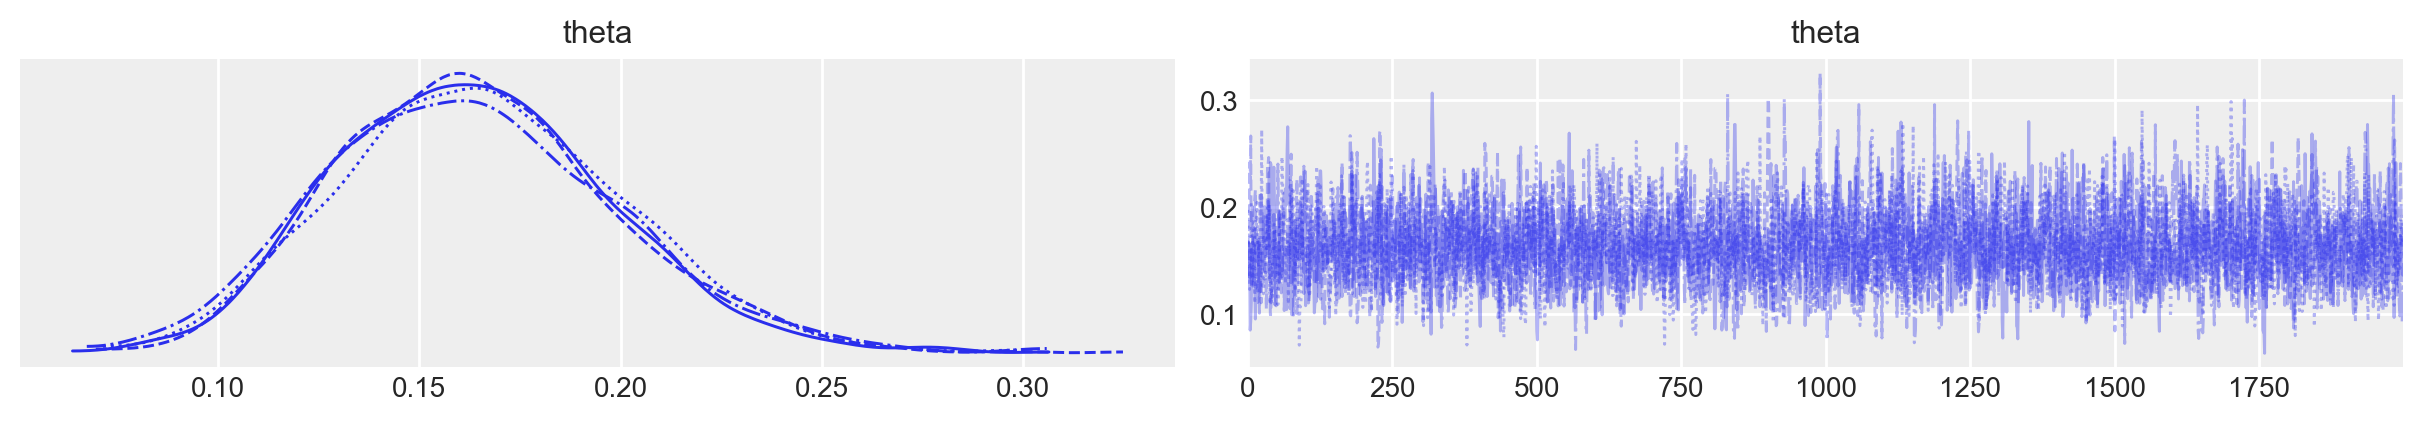

In [51]:
_ = az.plot_trace(fit_moma, var_names=("theta"), combined=False)

# Riscaldamento e monitoraggio della convergenza

Quando si eseguono catene di Markov, è importante assicurarsi che i campioni siano approssimativamente estratti dalla distribuzione a posteriori. Un modo standard per monitorare la convergenza è avviare più catene di Markov con inizializzazioni diverse (idealmente scelte da una distribuzione iniziale diffusa) e misurare se stanno producendo campioni dalla stessa distribuzione.

## Riscaldamento

Durante le fasi iniziali di riscaldamento, Stan cerca di trovare la regione di alta probabilità da cui campionare, adattare una buona dimensione del passo e stimare la varianza a posteriori. La varianza stimata viene utilizzata per migliorare l'efficienza del campionatore, un processo chiamato "precondizionamento". Precondizionare significa ridimensionare i parametri per rendere il campionamento più efficiente.

Stan può anche stimare una matrice di covarianza completa, che rappresenta le relazioni tra tutti i parametri. Utilizzando questa matrice, Stan può effettuare rotazioni e ridimensionamenti dei parametri per campionare in modo più efficace. In questo contesto, "rotazione e scalatura" si riferiscono alla trasformazione dei parametri in una nuova base (rotazione) e alla regolazione delle loro scale (scalatura) per facilitare il campionamento, rendendolo più rapido e affidabile. Per ulteriori dettagli su questi processi, si può fare riferimento a Neal (2011).

Il riscaldamento converge quando la dimensione del passo e le stime della covarianza a posteriori diventano stabili. Con più catene, è possibile verificare che tutte convergano verso una dimensione del passo e una stima della covarianza simili. A meno che non ci siano problemi, generalmente non misuriamo la convergenza dell'adattamento, ma piuttosto se otteniamo campioni a posteriori ragionevoli dopo il riscaldamento.

Durante la fase di riscaldamento, Stan non produce una catena di Markov coerente perché utilizza la memoria per adattarsi alle condizioni del modello. Questo adattamento serve a trovare i migliori parametri di campionamento. Tuttavia, una volta terminato il riscaldamento e iniziata la fase di campionamento, Stan inizia a produrre una vera e propria catena di Markov.

Le nostre analisi a posteriori si baseranno esclusivamente sui campioni generati durante questa fase di campionamento, non sui campioni raccolti durante il riscaldamento. È comunque possibile salvare ed esaminare i campioni del riscaldamento per comprendere meglio come il processo di adattamento è avvenuto e se ci sono stati problemi.

## Riduzione potenziale della scala e $\widehat{R}$

Stan utilizza la statistica di *riduzione potenziale della scala* $\widehat{R}$ (pronunciata "R hat"). Dato un insieme di catene di Markov, Stan divide ciascuna di esse a metà per assicurarsi che la prima metà e la seconda metà della catena concordino, quindi calcola le varianze all'interno di ciascuna catena e tra tutte le catene e le confronta. La statistica $\widehat{R}$ converge a 1 quando le catene di Markov convergono alla stessa distribuzione.

## Quante catene per quanto tempo? 

Una semplice regola empirica consiste nell'eseguire quattro catene finché $\widehat{R} \leq 1.01$ e la dimensione campionaria effettiva (ESS) è superiore a 100. La raccomandazione di avere una dimensione campionaria effettiva di "soli" 100 è dovuta al fatto che questo valore implica un errore standard pari a $\frac{1}{10}$ della deviazione standard. Poiché la deviazione standard a posteriori rappresenta l'incertezza residua, calcolare le medie con una precisione maggiore è raramente utile.

Il modo più semplice per ottenere $\widehat{R} \leq 1.01$ e $N_{\text{eff}} > 100$ è iniziare con 100 iterazioni di riscaldamento e 100 iterazioni di campionamento. Se i valori di $\widehat{R}$ sono troppo alti o se la dimensione campionaria effettiva è troppo bassa, raddoppiare il numero di iterazioni di riscaldamento e di campionamento e riprovare. Eseguire più iterazioni di riscaldamento è importante perché il campionamento non sarà efficiente se il riscaldamento non è convergente. Utilizzare lo stesso numero di iterazioni di riscaldamento e di campionamento può comportare un costo massimo doppio rispetto alle impostazioni ottimali, che non sono note in anticipo.

Anche se si utilizzano più di quattro catene, è necessario assicurarsi che la dimensione campionaria effettiva sia almeno 25 per catena. Non è tanto per l'inferenza, quanto per garantire la fiducia nello stimatore della dimensione campionaria effettiva, che non è affidabile se è molto inferiore. Un modo per verificare l'adeguatezza dello stimatore ESS è raddoppiare il numero di campioni e assicurarsi che anche l'ESS raddoppi. Se ciò non accade, significa che la prima stima dell'ESS non è affidabile.

## Esecuzione delle catene contemporaneamente

È possibile impostare il numero di catene da eseguire utilizzando l'argomento `chains` del metodo `sample()`. Inoltre, è possibile controllare quante catene possono essere eseguite contemporaneamente con l'argomento `parallel_cores` (che per default è impostato su 1, ovvero esecuzione sequenziale).

Se il numero massimo di catene parallele è impostato troppo basso, le risorse della CPU potrebbero non essere sfruttate appieno. Al contrario, se è impostato troppo alto, la CPU o la memoria potrebbero diventare il collo di bottiglia, rallentando le prestazioni complessive rispetto all'esecuzione con un numero inferiore di catene parallele.

In progetti personali sul nostro hardware, l'obiettivo è solitamente ottenere la massima dimensione campionaria effettiva nel minor tempo possibile. Tuttavia, a volte è necessario lasciare abbastanza potenza di elaborazione per continuare a lavorare su altre attività come documenti, email, ecc.

### Matrici, Vettori o Array in Stan

Stan offre vari tipi di dati per gestire operazioni di algebra lineare e per definire strutture di dati più generali come gli array. Capire le differenze tra questi tipi è fondamentale per sapere cosa possiamo fare con essi e per ottimizzare la velocità di esecuzione del nostro modello.

1. **Tipi di base per l'algebra lineare**:
   - **`vector`**: un vettore colonna di dimensione N.
   - **`row_vector`**: un vettore riga di dimensione N.
   - **`matrix`**: una matrice di dimensioni N1 × N2.

2. **Array**:
   - Gli array possono essere creati con qualsiasi tipo di elemento e possono avere più dimensioni. Ad esempio:
     - `array[N] real a;` definisce un array unidimensionale di numeri reali.
     - `array[N1, N2] real m;` definisce un array bidimensionale di numeri reali.

3. **Intercambiabilità e limitazioni**:
   - Anche se possiamo usare sia `vector` che `array` per contenitori unidimensionali, l'algebra matriciale (come la moltiplicazione) è definita solo per vettori e matrici, non per array.
   - Alcune funzioni, come `normal_lpdf`, accettano sia vettori che array.

4. **Esempi pratici**:
   - Quando definiamo una media (`mu`) come somma di un parametro (`alpha`) e il prodotto di un vettore di carichi (`c_load`) con un coefficiente (`beta`), dobbiamo usare i vettori:
     ```stan
     vector[N] mu = alpha + c_load * beta;
     ```
   - Per utilizzare un generatore di numeri casuali (_rng) in modo vettoriale, dobbiamo usare un array:
     ```stan
     array[N] real p_size_pred = normal_rng(alpha + c_load * beta, sigma);
     ```

In sintesi, la scelta tra `vector`, `row_vector`, `matrix` e `array` dipende dalle operazioni che si desidera eseguire e dalle specifiche esigenze del modello. Scegliere il tipo di dato appropriato permette di sfruttare appieno le funzionalità di Stan e ottimizzare le prestazioni del modello.

## Modello di esecuzione di Stan

I programmi Stan sono composti da diversi blocchi. Ecco una panoramica di ciascun blocco, di quando viene eseguito e di cosa fa. Nessuno di questi blocchi è obbligatorio, ma se presenti, devono seguire quest'ordine.

| **Blocco** | **Quando viene eseguito** | **Cosa fa** |
|:--|:--|:--|
| `functions` | secondo necessità | Definizione delle funzioni create dall'utente |
| `data` | una volta | Lettura dei dati per costruire il modello |
| `transformed data` | una volta | Definizione dei dati trasformati |
| `parameters` | una volta / densità logaritmica | Definizione dei parametri con i relativi vincoli |
| `transformed parameters` | una volta / densità logaritmica | Definizione dei parametri trasformati |
| `model` | una volta / densità logaritmica | Valutazione della densità logaritmica del modello |
| `generated quantities` | una volta / per estrazione | Definizione delle quantità generate |

### Dati e dati trasformati

Il blocco _data_ contiene solo le dichiarazioni delle variabili. Queste variabili vengono lette una volta durante il caricamento dei dati.

Il blocco _transformed data_ contiene sia dichiarazioni che definizioni delle variabili. Questo blocco serve per calcolare nuove variabili a partire dai dati originali, come predittori standardizzati o costanti per i priori. Può anche includere la generazione pseudocasuale di numeri. Viene eseguito una volta, dopo la lettura dei dati, per definire le nuove variabili trasformate.

In ogni blocco, tutte le variabili devono avere il loro tipo e dimensione dichiarati (che possono dipendere dai dati). Le variabili locali all'interno dei blocchi, invece, sono dichiarate senza specificare la dimensione.

I vincoli sulle variabili nel blocco _data_ vengono controllati mentre i dati vengono letti, mentre quelli nel blocco _transformed data_ vengono verificati alla fine dell'esecuzione del blocco. Se ci sono violazioni dei vincoli nei dati o nei dati trasformati, si genera un'eccezione che interrompe l'esecuzione del programma.

Le variabili definite nel blocco _transformed data_ possono essere assegnate una volta, ma non possono essere riassegnate dopo l'esecuzione del blocco.


### Parametri e Parametri Trasformati

Il blocco _parameters_ serve a dichiarare le variabili su cui è basato il modello. In pratica, si tratta di elencare i parametri che il modello utilizzerà, specificandone le dimensioni. Quando il blocco viene eseguito, vengono forniti i valori concreti di questi parametri.

I vincoli sui parametri sono utilizzati per trasformare le variabili vincolate in variabili non vincolate. Ad esempio, se una variabile ha un vincolo `lower=0` (cioè deve essere maggiore o uguale a zero), questa variabile viene trasformata usando il logaritmo per renderla non vincolata. È essenziale dichiarare tutti i vincoli necessari sui parametri affinché il modello funzioni correttamente su tutto lo spazio dei parametri.

Il blocco _transformed parameters_ permette di definire nuove variabili che sono funzioni dei parametri originali e dei dati. Gli utenti possono creare le loro trasformazioni dei parametri in questo blocco. I vincoli su queste nuove variabili vengono verificati alla fine dell'esecuzione del blocco. Se questi vincoli non sono rispettati, viene generata un'eccezione che di solito porta al rifiuto della proposta corrente.

Le variabili dichiarate nel blocco _parameters_ sono simili agli argomenti di una funzione: la funzione di densità logaritmica del programma Stan prende questi parametri come input. Quindi, i valori dei parametri vengono sempre forniti dall'esterno del programma Stan.

Dopo l'esecuzione del blocco _transformed parameters_, le variabili dichiarate in esso non possono essere modificate ulteriormente.

La differenza principale tra le variabili dichiarate come locali nel blocco _model_ e quelle nel blocco _transformed parameters_ è che le variabili trasformate vengono stampate e sono disponibili anche nel blocco _generated quantities_.

### Modello

Lo scopo del blocco _model_ è definire la funzione che calcola la densità logaritmica del modello. Una volta caricati i dati, il compito principale di un programma Stan è fornire questa funzione di densità logaritmica non normalizzata sui parametri non vincolati. Algoritmi esterni, come ottimizzatori, campionatori o metodi di inferenza variazionale, forniranno i valori dei parametri non vincolati per la valutazione.

Il valore della densità logaritmica non normalizzata calcolato dal modello viene conservato in una variabile chiamata `target`. Le densità posteriori (che ci interessano) sono calcolate moltiplicando i fattori delle funzioni di densità o massa di probabilità. In termini logaritmici, questo equivale ad aggiungere i termini delle funzioni di densità o massa non normalizzate alla `target`.

L'accumulatore `target` parte da zero e viene incrementato durante l'esecuzione del programma Stan. Come accennato prima, la prima cosa che questa funzione di densità logaritmica non normalizzata fa è trasformare i parametri vincolati in non vincolati e aggiungere un aggiustamento logaritmico per il cambio di variabili alla `target`. Questo processo è automatico e fornisce i valori dei parametri trasformati al codice che verrà eseguito successivamente nel blocco _model_.

La densità logaritmica accumulata in `target` può essere incrementata direttamente, come mostrato nell'esempio seguente:
```stan
target += -0.5 * x^2;
```
Anche se non è possibile usare direttamente `target` come variabile, il suo valore attuale può essere recuperato tramite la funzione `target()`, utile per il debugging.

Le istruzioni di campionamento sono una scorciatoia per incrementare `target`. Ad esempio, l'istruzione
```stan
x ~ normal(0, 1);
```
è equivalente a
```stan
target += normal_lupdf(x | 0, 1);
```
Qui, `_lupdf` indica che si tratta di una funzione di densità di probabilità logaritmica non normalizzata.

La barra verticale `|` è utilizzata per separare le variabili osservate dai parametri. La notazione `lpdf` denota una funzione di densità di probabilità logaritmica, mentre `lpmf` indica una funzione di massa di probabilità logaritmica. Le varianti `lupdf` e `lupmf` sono le loro controparti non normalizzate, che possono omettere le costanti di normalizzazione che non dipendono dai parametri. A meno che non siano necessarie, ad esempio in un componente di un modello di mescolanza, è più efficiente usare le forme `lupdf` e `lupmf` incrementando direttamente `target` o tramite istruzioni di campionamento.

### Quantità generate

Il blocco _generated quantities_ viene eseguito una volta per ogni campione generato, anziché ogni volta che viene calcolata la densità logaritmica. Con algoritmi come il campionamento Monte Carlo Hamiltoniano, ogni campione può richiedere diverse valutazioni della densità logaritmica.

Un vantaggio delle quantità generate è che vengono calcolate utilizzando numeri in virgola mobile a doppia precisione, il che le rende molto efficienti. Questo blocco può anche utilizzare numeri pseudocasuali. I vincoli sui dati generati vengono verificati alla fine del blocco, ma eventuali errori non causano il rigetto del campione, solo possibili avvertimenti o valori non definiti (NaN).

Le quantità generate non influenzano il calcolo della densità logaritmica, ma sono comunque una parte importante del modello statistico. Sono utilizzate principalmente per fare previsioni su nuovi dati, basandosi sui parametri stimati dal modello. Questo processo è noto come inferenza predittiva posteriore. In altre parole, ci permette di fare previsioni su nuovi dati utilizzando i valori dei parametri generati dal modello.

Esempi di utilizzo delle quantità generate includono la previsione di nuovi valori o il calcolo di statistiche derivate dai parametri stimati. Le quantità generate offrono un modo per esplorare ulteriormente il comportamento del modello e fare inferenze utili dai dati simulati.

## Considerazioni Conclusive

L'inferenza bayesiana ha subito una trasformazione significativa grazie all'introduzione dei metodi MCMC, che permettono di esplorare distribuzioni complesse anche in assenza di soluzioni analitiche o campionamenti indipendenti. Tra questi metodi, l'Hamiltonian Monte Carlo (HMC) si distingue per la sua efficienza e capacità di scalare su modelli ad alta dimensione. Stan, con la sua implementazione di HMC, ha reso accessibile l'analisi di modelli bayesiani complessi, consentendo di ottenere risultati in tempi ragionevoli anche per problemi computazionalmente impegnativi. L'introduzione a Stan mostra come questo strumento non solo amplia la gamma di modelli che possiamo affrontare, ma lo fa in modo rigoroso e altamente efficiente.

## Esercizi

::: {#exr-poisson-births}

Un decennio dopo la pubblicazione della regola di Bayes, Laplace utilizzò la funzione beta di Eulero per derivare formalmente la distribuzione a posteriori. Laplace raccolse dati sul sesso dei bambini nati vivi a Parigi tra il 1745 e il 1770:

| Sesso   | Nascite vive |
|---------|--------------|
| Femmina | 105.287      |
| Maschio | 110.312      |

Laplace si chiese se, sulla base di questi dati, la probabilità di nascita dei maschi fosse superiore a quella delle femmine.

Analizzare il problema di Laplace utilizzando Stan.

:::

## Informazioni sull'Ambiente di Sviluppo

In [52]:
%load_ext watermark
%watermark -n -u -v -iv -w -m -p cmdstanpy

Last updated: Mon Oct 14 2024

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

cmdstanpy: 1.2.4

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 24.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

seaborn   : 0.13.2
logging   : 0.5.1.2
cmdstanpy : 1.2.4
matplotlib: 3.9.1
pandas    : 2.2.2
numpy     : 1.26.4
arviz     : 0.18.0

Watermark: 2.4.3

